In [2]:
from solver import Solver
from model import Net
import math
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
from experiment import get_data_loader
from lossfn import *

In [3]:
def get_train_range(dim):
    if dim == 2:
        train_range = range(1, 51, 1)
    elif dim == 3:
        train_range = range(10, 501, 10)
    elif dim == 5:
        train_range = range(50, 5001, 50)
    elif dim == 10:
        train_range = list(range(2500, 10000, 2500)) + list(range(10000, 30000, 5000)) + list(range(30000, 500001, 10000))
    return train_range

In [4]:
def get_checkpoint_dir(dim, ntrain, lossfn, seed=1683):
    return 'checkpoints/checkpoints_lossfn/checkpoints_dim-{}_ntrain-{}_lossfn-{}_seed-{}/'.format(dim, ntrain, lossfn, seed)
def get_checkpoint_dir2(dim, ntrain, lossfn, seed=1683):
    return 'checkpoints/checkpoints_lossfn2/checkpoints_dim-{}_ntrain-{}_lossfn-{}_seed-{}/'.format(dim, ntrain, lossfn, seed)

In [5]:
loss_fns = ['error', 'det', 'norm', 'detnorm']

In [6]:
def fn_pred_normed(pred):
    norms = torch.norm(pred.data, 2, 1)
    pred_normed = pred / norms.view(norms.shape[0], 1)
    return pred_normed

In [7]:
def plot_train_loss(dim, paths, logscale=True, labels=[], includeTest=False):
    plt.figure(figsize=(13,7))
    if len(labels) == 0:
        labels = [''] * len(paths)
    for path, label in zip(paths, labels):
        # Plot train loss
        model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
        solver = Solver(model)
        solver.load_checkpoint(path)
        for key in solver.hist["individual_train_losses"]:
            plt.plot(solver.hist["iterations"], solver.hist["individual_train_losses"][key], label=key+'_'+label)
        if includeTest:
            plt.plot(solver.hist["iterations"], solver.hist["test_loss"], label='test_'+label)
    plt.legend()
    if logscale:
        plt.yscale('log')
    plt.ylabel("train loss")
    plt.xlabel("iteration")
    plt.show()

In [8]:
def plot_test_loss(dim, train_range, keys, get_path, logscale=True, min_n_train=0, max_n_train=float('inf'), includeNormed=False):
    plt.figure(figsize=(13,7))
    if includeNormed:
        test_loader = get_data_loader(dim, 512, seed=0, shuffle=False, batch_size=512)
    for key in keys:
        test_loss = []
        test_loss_normed = []
        ntrains = []
        for n_train in train_range:
            if n_train < min_n_train or n_train > max_n_train:
                continue
            model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
            solver = Solver(model)
            filepath = get_path(key, n_train)
            if os.path.exists(filepath):
                ntrains.append(n_train)
                solver.load_checkpoint(filepath)
                test_loss.append(solver.hist["test_loss"][-1])
                if includeNormed:
                    solver.fn_pred = fn_pred_normed
                    test_loss_normed.append(solver.test(test_loader, prints=False))
        plt.plot(ntrains, test_loss, label=key)
        if includeNormed:
            plt.plot(ntrains, test_loss_normed, label=str(key)+'_testnormed')
    plt.legend()
    if logscale:
        plt.yscale('log')
    plt.ylabel("test loss")
    plt.xlabel("n_train")
    plt.show()

In [9]:
def plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, logscale=True, min_n_train=0, max_n_train=float('inf'), includeNormed=False, percentiles=True, max_iteration=float("inf")):
    plt.figure(figsize=(13,7))
    if includeNormed:
        test_loader = get_data_loader(dim, 512, seed=0, shuffle=False, batch_size=512)
    for key in keys:
        test_loss = []
        test_loss_normed = []
        ntrains = []
        for n_train in train_range:
            if n_train < min_n_train or n_train > max_n_train:
                continue
            test_loss_n_train = []
            test_loss_normed_n_train = []
            ntrains.append(n_train)
            for stat_val in stat_range:
                model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
                solver = Solver(model)
                filepath = get_path(key, n_train, stat_val)
                if os.path.exists(filepath):
                    solver.load_checkpoint(filepath)
                    test_index = len(solver.hist["test_loss"]) - 1
                    while (solver.hist["iterations"][test_index] > max_iteration):
                        test_index -= 1
                    test_loss_n_train.append(solver.hist["test_loss"][test_index])
                    if includeNormed:
                        solver.fn_pred = fn_pred_normed
                        test_loss_normed_n_train.append(solver.test(test_loader, prints=False))
                else:
                    print('Missing filepath:')
                    print(filepath)
            test_loss.append(test_loss_n_train)
            test_loss_normed.append(test_loss_normed_n_train)
        test_loss = np.array(test_loss)
        test_loss_normed = np.array(test_loss_normed)
        if len(test_loss):
            if percentiles:
                p = plt.plot(ntrains, np.median(test_loss, axis=1), label=key)
                color = p[0].get_color()
                plt.plot(ntrains, np.percentile(test_loss, 80, axis=1), linestyle='--', color=color, linewidth=0.5)
                plt.plot(ntrains, np.percentile(test_loss, 20, axis=1), linestyle='--', color=color, linewidth=0.5)
            else: 
                plt.errorbar(ntrains, test_loss.mean(axis=1), yerr=test_loss.std(axis=1), capsize=5, markeredgewidth=2, label=key)
        if includeNormed:
            plt.errorbar(ntrains, test_loss_normed.mean(axis=1), yerr=test_loss_normed.std(axis=1), capsize=5, markeredgewidth=2, label=str(key)+'_testnormed')
    plt.legend()
    plt.xlabel("number of training data points")
    plt.ylabel("Test loss")
    if logscale:
        plt.yscale('log')
    plt.show()

In [10]:
def get_angles_norms_dets(test_loader, train_loader, solver):
    all_angles = []
    all_norms = []
    all_dets = []
    all_l2 = []
    for loader in [test_loader, train_loader]:
        for (points, angles, points_rotated) in loader:
            output_matrix, prediction = solver.forward(angles, points)
            all_angles += [x.item() for x in angles]
            all_norms += list(torch.norm(prediction, 2, 1).data.numpy())
            all_dets += [torch.det(mat).item() for mat in output_matrix]
            all_l2 += list(torch.sum(torch.nn.functional.mse_loss(prediction, points_rotated, reduction='none'), dim=1).detach().numpy())
    angles_norms = list(zip(all_angles, all_norms, all_dets, all_l2))
    angles_norms_sorted = list(zip(*sorted(angles_norms)))
    return angles_norms_sorted

In [11]:
def get_angles_stats_buckets(test_loader, train_loader, solver, n_buckets=50):
    angles_stats = get_angles_norms_dets(test_loader, train_loader, solver)
    angles_stats = [list(l) for l in zip(*angles_stats)]
    angle_min, angle_max = -math.pi, math.pi
    linspace = np.linspace(angle_min, angle_max, n_buckets+1)
    angles = [(linspace[i] + linspace[i+1])/2 for i in range(n_buckets)]
    buckets = [[] for _ in angles]
    linspace_i = 0
    for stats in angles_stats:
        angle = stats[0]
        while angle > linspace[linspace_i + 1]:
            linspace_i += 1
        buckets[linspace_i].append(stats)
    return angles, [list(zip(*b)) for b in buckets]

# Find best learning rate

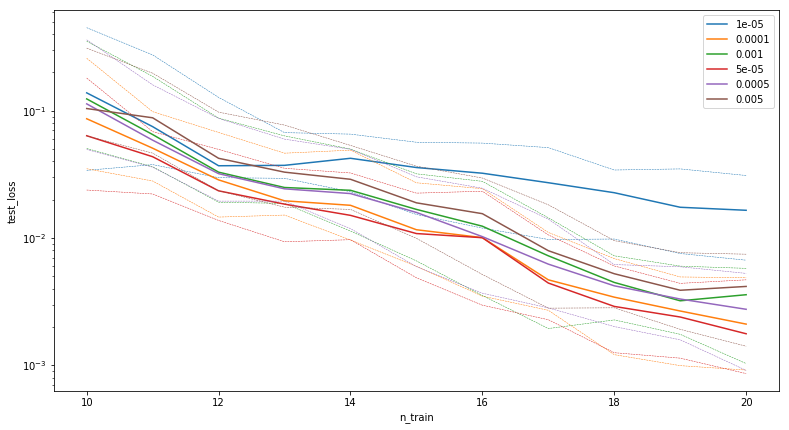

In [131]:
dim = 2
train_range = range(10, 21, 1)
keys = [1e-5, 1e-4, 1e-3] + [5*1e-5, 5*1e-4, 5*1e-3]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_lr_statistical/'
    checkpoint_dir += 'dim-{}_lr-{}_ntrain-{}_lossfn-{}_seed-{}/'.format(dim, key, n_train, 'error', stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, max_iteration=50000)

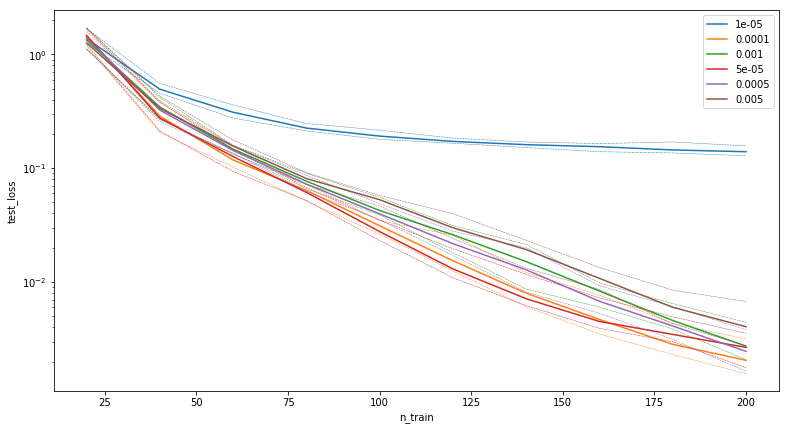

In [126]:
dim = 3
train_range = range(20, 201, 20)
keys = [1e-5, 1e-4, 1e-3] + [5*1e-5, 5*1e-4, 5*1e-3]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_lr_statistical/'
    checkpoint_dir += 'dim-{}_lr-{}_ntrain-{}_lossfn-{}_seed-{}/'.format(dim, key, n_train, 'error', stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path)

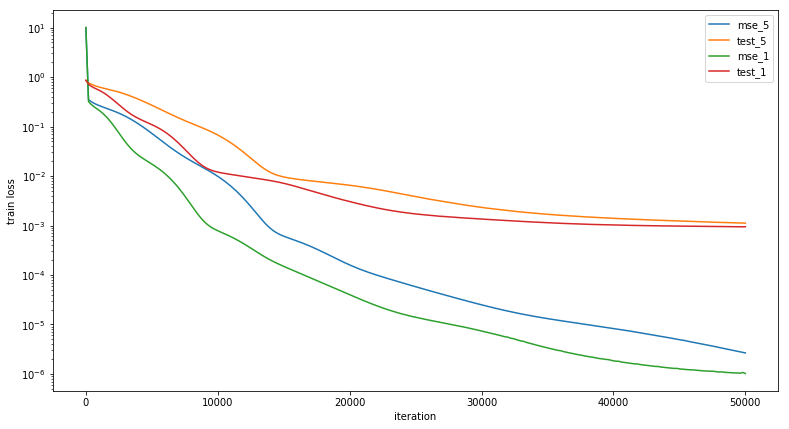

In [129]:
dim = 2
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_lr_statistical/'
    checkpoint_dir += 'dim-{}_lr-{}_ntrain-{}_lossfn-{}_seed-{}/'.format(dim, key, n_train, 'error', stat_val)
    return checkpoint_dir + 'final.pkl'
plot_train_loss(dim, [get_path(5*1e-5, 20, 1683), get_path(1e-4, 20, 1683)], labels=["5", "1"], includeTest=True)

## Determinant weight

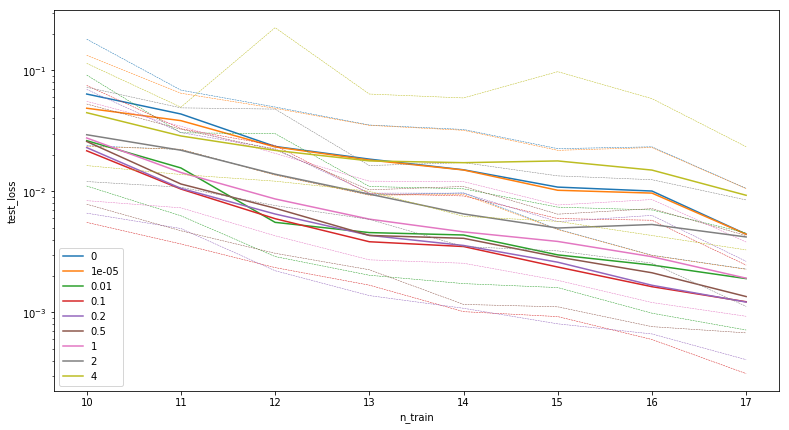

In [149]:
dim = 2
train_range = range(10, 18, 1)
keys = [0, 1e-5, 1e-2, 0.1, 0.2, 0.5, 1, 2, 4]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_detweight3/'
    checkpoint_dir += 'dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(dim, key, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path)

In [142]:
dim = 3
train_range = range(20, 201, 20)
keys = [0, 1e-5, 1e-2, 0.1, 0.2, 0.5, 1, 2, 4]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_detweight4/'
    checkpoint_dir += 'dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(dim, key, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path)

SyntaxError: 'return' outside function (<ipython-input-142-1a327efa400b>, line 1)

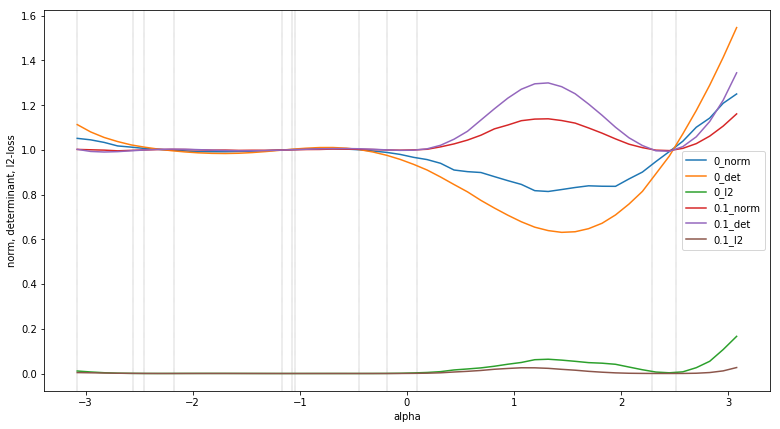

In [55]:
dim = 2
n_train = 12
train_seed = 1683
train_loader = get_data_loader(dim, n_train, seed=train_seed, shuffle=False, batch_size=512)
test_loader = get_data_loader(dim, 4096, seed=0, shuffle=False, batch_size=512)
model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
solver = Solver(model)
# solver.fn_pred = fn_pred_normed

plt.figure(figsize=(13,7))
for (points, angles, points_rotated) in train_loader:
    for angle in angles:
        plt.axvline(x=angle.item(), color='black', linestyle='--', linewidth=0.2)
for det_weight in [0, 0.1]:
    path = 'checkpoints/round2_detweight3/dim-{}_detweight-{}_ntrain-{}_seed-{}/final.pkl'.format(dim, det_weight, n_train, train_seed)
    solver.load_checkpoint(path)
    angles, buckets = get_angles_stats_buckets(test_loader, train_loader, solver)
    plt.plot(angles, [np.array(b[1]).mean() for b in buckets], label=str(det_weight)+'_'+'norm')
    plt.plot(angles, [np.array(b[2]).mean() for b in buckets], label=str(det_weight)+'_'+'det')
    plt.plot(angles, [np.array(b[3]).mean() for b in buckets], label=str(det_weight)+'_'+'l2')
plt.ylabel("norm, determinant, l2-loss")
plt.xlabel("alpha")
# plt.yscale('log')
plt.legend(loc='best')
plt.show()

## Norm weights

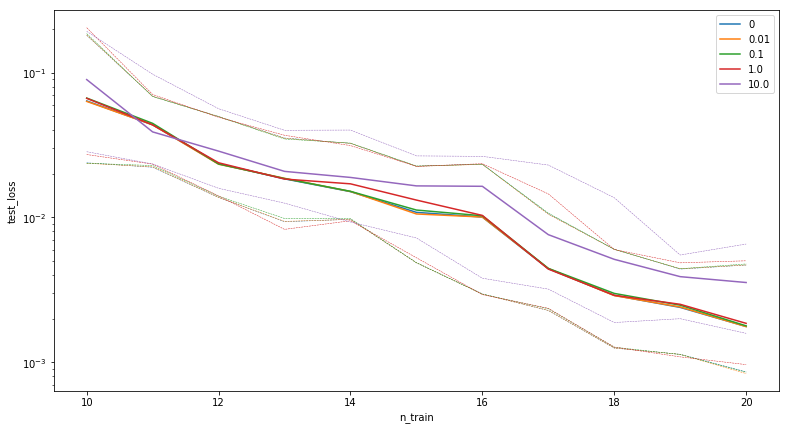

In [150]:
dim = 2
train_range = range(10, 21, 1)
keys = [0, 1e-2, 1e-1, 1e0, 1e1]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normweight2/'
    checkpoint_dir += 'dim-{}_normweight-{}_ntrain-{}_seed-{}/'.format(dim, key, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path)

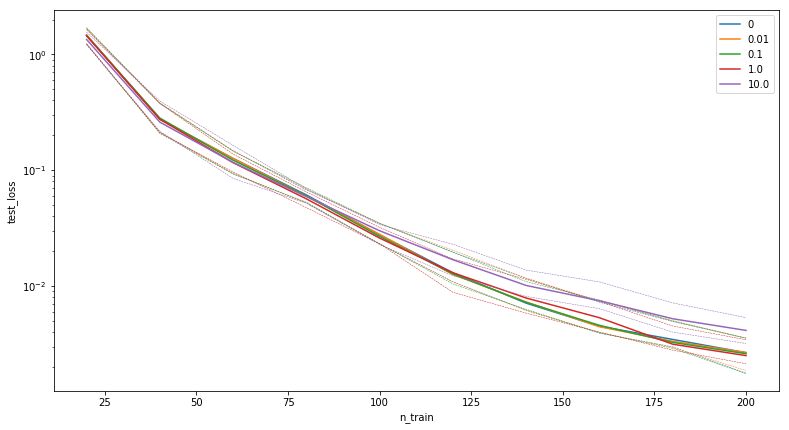

In [151]:
dim = 3
train_range = range(20, 201, 20)
keys = [0, 1e-2, 1e-1, 1e0, 1e1]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normweight2/'
    checkpoint_dir += 'dim-{}_normweight-{}_ntrain-{}_seed-{}/'.format(dim, key, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path)

In [54]:
#n_train = 20
#train_seed = 1694
#plot_train_loss(dim, ['checkpoints/round2_normweight2/dim-{}_normweight-{}_ntrain-{}_seed-{}/final.pkl'.format(dim, 0, n_train, train_seed),
#                     'checkpoints/round2_normweight2/dim-{}_normweight-{}_ntrain-{}_seed-{}/final.pkl'.format(dim, 1e1, n_train, train_seed)], labels=["0", "10"], includeTest=True)

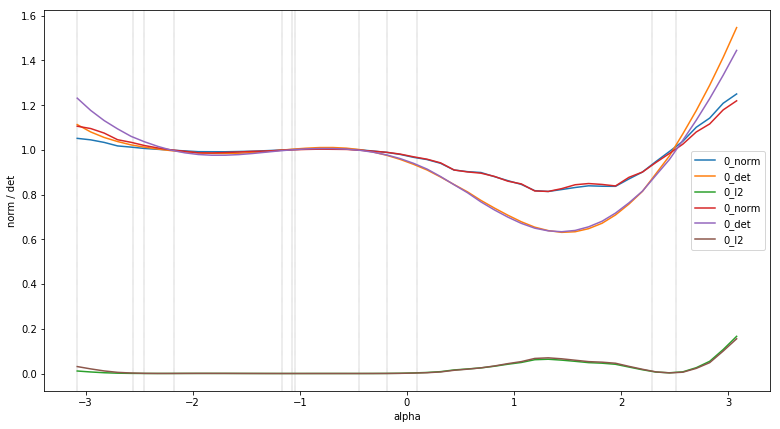

In [35]:
dim = 2
n_train = 12
train_seed = 1683
train_loader = get_data_loader(dim, n_train, seed=train_seed, shuffle=False, batch_size=512)
test_loader = get_data_loader(dim, 4096, seed=0, shuffle=False, batch_size=512)
model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
solver = Solver(model)
# solver.fn_pred = fn_pred_normed

plt.figure(figsize=(13,7))
for (points, angles, points_rotated) in train_loader:
    for angle in angles:
        plt.axvline(x=angle.item(), color='black', linestyle='--', linewidth=0.2)
for norm_weight in [0, 1e1]:
    path = 'checkpoints/round2_normweight2/dim-{}_normweight-{}_ntrain-{}_seed-{}/final.pkl'.format(dim, norm_weight, n_train, train_seed)
    solver.load_checkpoint(path)
    angles, buckets = get_angles_stats_buckets(test_loader, train_loader, solver)
    plt.plot(angles, [np.array(b[1]).mean() for b in buckets], label=str(det_weight)+'_'+'norm')
    plt.plot(angles, [np.array(b[2]).mean() for b in buckets], label=str(det_weight)+'_'+'det')
    plt.plot(angles, [np.array(b[3]).mean() for b in buckets], label=str(det_weight)+'_'+'l2')
plt.ylabel("norm / det")
plt.xlabel("alpha")
# plt.yscale('log')
plt.legend(loc='best')
plt.show()

## Regularization weights

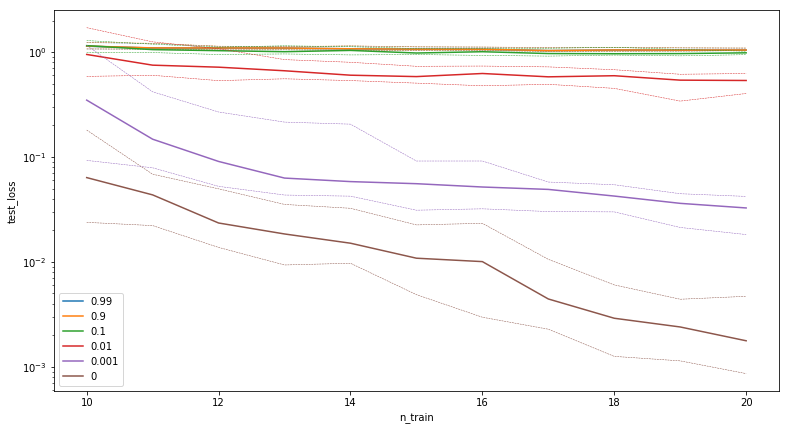

In [145]:
dim = 2
train_range = range(10, 21, 1)
keys = [0.99, 0.9, 0.1, 0.01, 0.001, 0]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_weight_decay2/'
    checkpoint_dir += 'dim-{}_ntrain-{}_weightdecay-{}_seed-{}/'.format(dim, n_train, key, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path)

In [152]:
dim = 3
train_range = range(20, 201, 20)
keys = [0.99, 0.9, 0.1, 0.01, 0.001, 0]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_weight_decay2/'
    checkpoint_dir += 'dim-{}_ntrain-{}_weightdecay-{}_seed-{}/'.format(dim, n_train, key, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path)

SyntaxError: 'return' outside function (<ipython-input-152-bfea883612e9>, line 1)

## Normed determinant

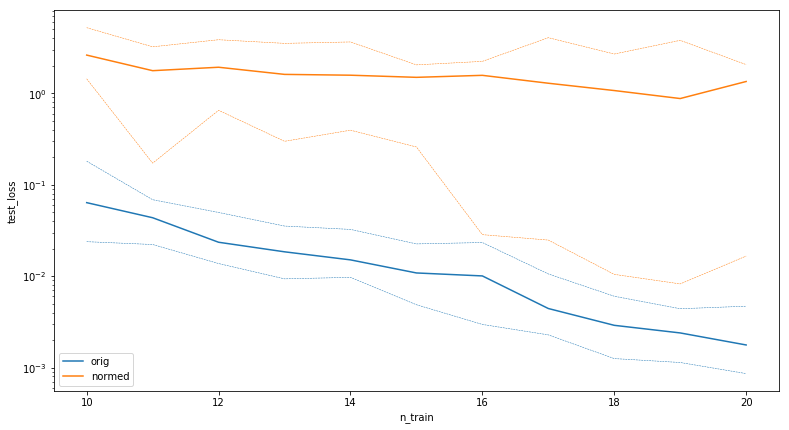

In [153]:
dim = 2
train_range = range(10, 21, 1)
keys = ["orig", "normed"]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normed_det/'
    checkpoint_dir += 'dim-{}_normeddet-{}_ntrain-{}_seed-{}/'.format(key, dim, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path)

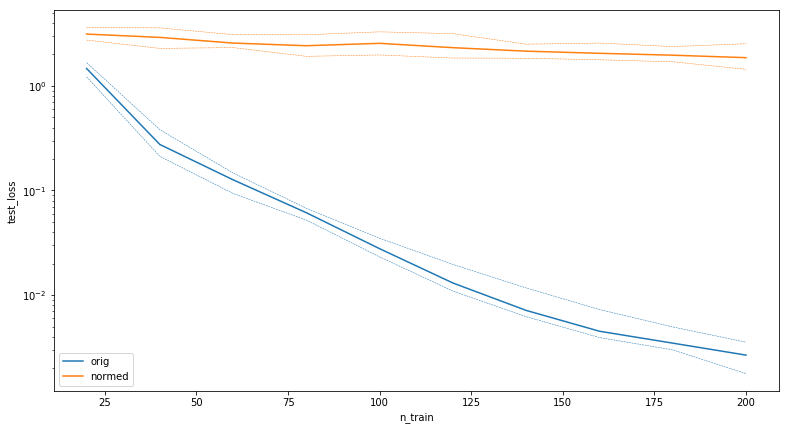

In [154]:
dim = 3
train_range = range(20, 201, 20)
keys = ["orig", "normed"]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normed_det/'
    checkpoint_dir += 'dim-{}_normeddet-{}_ntrain-{}_seed-{}/'.format(key, dim, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path)

## Normed prediction

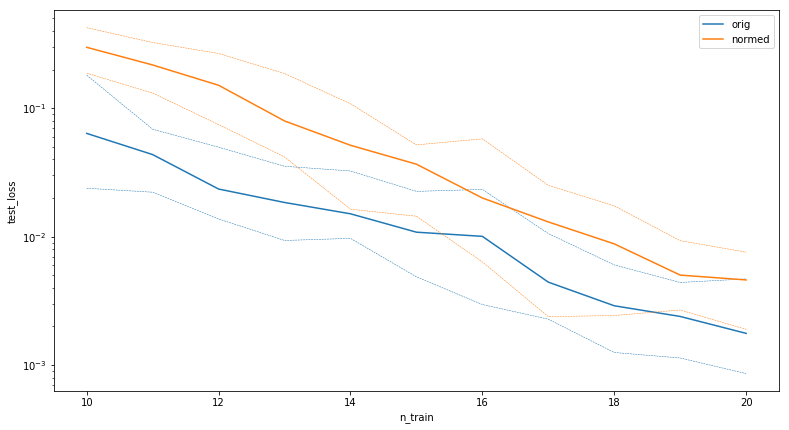

In [155]:
dim = 2
train_range = range(10, 21, 1)
keys = ["orig", "normed"]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normed_pred/'
    checkpoint_dir += 'dim-{}_normedpred-{}_ntrain-{}_seed-{}/'.format(key, dim, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path)

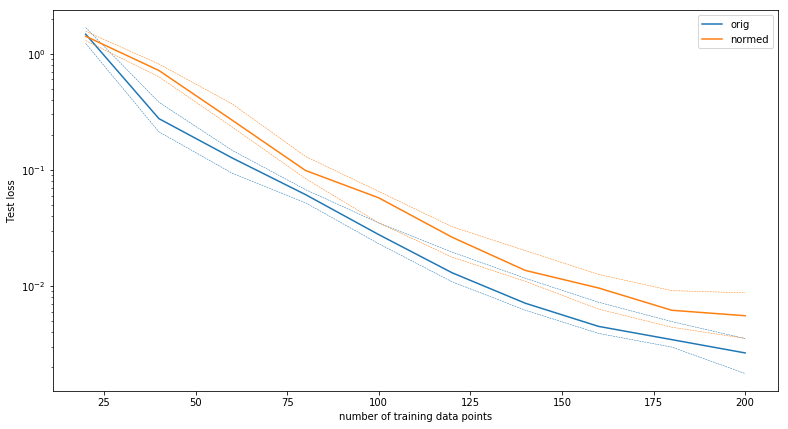

In [159]:
dim = 3
train_range = range(20, 201, 20)
keys = ["orig", "normed"]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normed_pred/'
    checkpoint_dir += 'dim-{}_normedpred-{}_ntrain-{}_seed-{}/'.format(key, dim, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path)